In [1]:
# import and set options
import rpy2
%load_ext rpy2.ipython
%matplotlib inline
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import glob
import os
import scipy.stats as stats
import matplotlib as mpl
import utils
mpl.rcParams['pdf.fonttype'] = 42

ModuleNotFoundError: No module named 'rpy2'

## Summary of CHASM2 discovery analysis

### Read mutations

In [44]:
# read in significant mutations
df = utils.read_all_results()

### OncoKB Analysis

In [45]:
#read oncokb
oncokb = pd.read_table('data/oncokb_4_3_2017.txt')
oncokb['HGVSp_Short'] = 'p.' + oncokb['Alteration']
oncokb = oncokb.rename(columns={'Gene': 'Hugo_Symbol'})
oncokb['OncoKB'] = oncokb['Oncogenicity'].isin(['Oncogenic', 'Likely Oncogenic']).astype(int)

# merge in oncokb annotations
merge_cols = ['Hugo_Symbol', 'HGVSp_Short']
merged_df = pd.merge(df, oncokb[merge_cols+['OncoKB']], on=merge_cols, how='left')
merged_df['OncoKB'] = merged_df['OncoKB'].fillna(0)
is_tp53 = merged_df['Hugo_Symbol']=='TP53'
is_dna_bind_domain = (merged_df['Protein_position'].astype(int)>=102) & (merged_df['Protein_position'].astype(int)<=292)
merged_df.loc[is_tp53 & is_dna_bind_domain, 'OncoKB'] = 1

# make a flag column for oncokb
merged_df['OncoKB_flag'] = 'No'
merged_df.loc[(merged_df['OncoKB']==1), 'OncoKB_flag'] = 'Yes'
merged_df.loc[(merged_df['Hugo_Symbol']=='TP53') & (merged_df['OncoKB']==1), 'OncoKB_flag'] = 'Yes (TP53)'

In [46]:
mycols = ['ACC_flag', u'BLCA_flag', u'BRCA_flag',
          'CESC_flag', u'CHOL_flag', u'COAD_flag', 
          'DLBC_flag', u'ESCA_flag', u'GBM_flag', 
          'HNSC_flag', u'KICH_flag', u'KIRC_flag',
          'KIRP_flag', u'LAML_flag', u'LGG_flag', 
          'LIHC_flag', u'LUAD_flag', u'LUSC_flag', 
          'MESO_flag', u'OV_flag', u'PAAD_flag', 
          'PCPG_flag', u'PRAD_flag', u'READ_flag',
          'SARC_flag', u'STAD_flag', u'TGCT_flag',
          'THCA_flag', u'THYM_flag',  u'UCEC_flag',
          'UCS_flag', u'UVM_flag',]
tmp_df = pd.melt(merged_df, value_vars=mycols, id_vars='OncoKB_flag', value_name='significant', var_name='cancer type').dropna()
tmp_df = tmp_df[tmp_df['significant']==1]
tmp2_df = tmp_df.groupby('cancer type')['OncoKB_flag'].value_counts().reset_index(name='number of mutations')
plot_df = tmp2_df.pivot_table('number of mutations',  'OncoKB_flag', 'cancer type').fillna(0)
rename_dict = {c: c.split('_')[0] for c in plot_df.columns}
plot_df = plot_df.rename(columns=rename_dict)

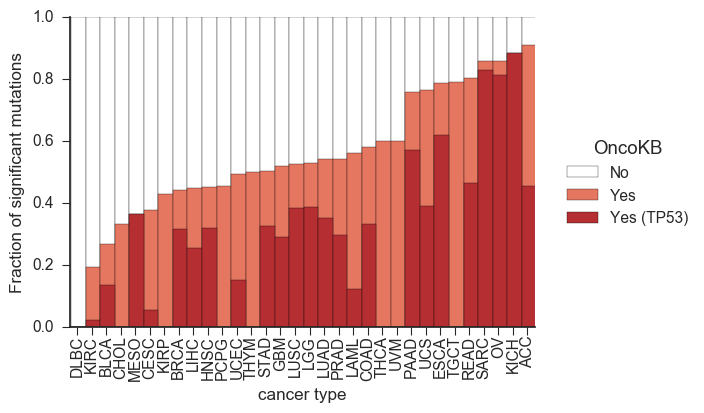

In [94]:
num_oncokb = plot_df.loc[['Yes', 'Yes (TP53)'],:].sum()
num_oncokb_tp53 = plot_df.loc['Yes (TP53)',:]
total = plot_df.sum()
frac_oncokb = num_oncokb / total
frac_oncokb = frac_oncokb.sort_values()
frac_oncokb_tp53 = num_oncokb_tp53 / total
with sns.axes_style('ticks'), sns.plotting_context('paper', font_scale=1.4):
    sns.barplot(frac_oncokb.index, [1]*len(total), color='white', label='No')
    sns.barplot(frac_oncokb.index, frac_oncokb, color=sns.color_palette("Reds", 3)[1], label='Yes')
    sns.barplot(frac_oncokb.index, frac_oncokb_tp53[frac_oncokb.index], color=sns.color_palette("Reds", 3)[2], label='Yes (TP53)')
    sns.despine()
    myleg = plt.legend(loc='upper center', title='OncoKB', bbox_to_anchor=(1.2, .65), ncol=1)
    plt.ylabel('Fraction of significant mutations')
    plt.gca().set_xticklabels(plt.gca().get_xticklabels(), rotation=90, ha='center')
    plt.gca().tick_params(axis='x', which='major', pad=0)
    #plt.gca().set_ylim((0, 90))
    myax = plt.gca()
    for bar in myax.patches:
        bar.set_width(1)
    plt.gcf().set_size_inches(6,4)
    plt.savefig('figures/fraction_onckb.pdf', bbox_inches='tight', bbox_extra_artists=[myleg])

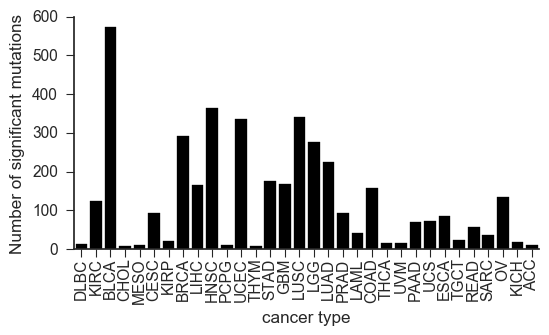

In [96]:
with sns.axes_style('ticks'), sns.plotting_context('paper', font_scale=1.4):
    sns.barplot(frac_oncokb.index, total[frac_oncokb.index], color='black')
    plt.gca().set_xticklabels(plt.gca().get_xticklabels(), rotation=90, ha='center')
    plt.gca().tick_params(axis='x', which='major', pad=0)
    sns.despine()
    plt.ylabel('Number of significant mutations')
    plt.gcf().set_size_inches(6, 3)
    plt.savefig('figures/number_signif.pdf')

### Analyze mutation rarity

Analyze the rarity of significant mutations.

#### CHASM2

Analyze the rarity of mutations found significant by CHASM2.

In [68]:
# read in information about the rarity of drivers
rare_df = utils.read_all_rarity_results(base_dir='data/rarity_analysis_v2/')

In [114]:
rare_df['PANCAN']

common          0.354612
intermediate    0.290267
rare            0.355121
Name: PANCAN, dtype: float64

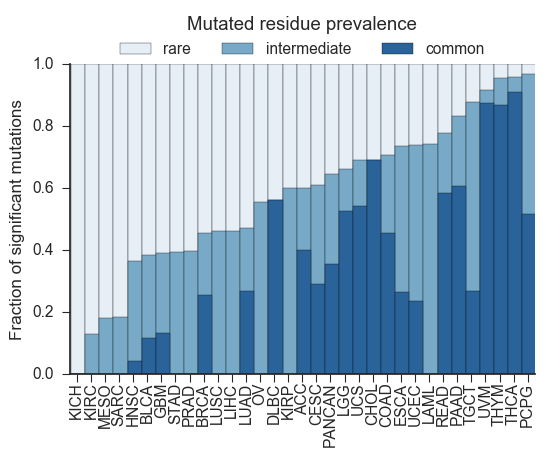

In [97]:
intermediate = rare_df.loc[['common', 'intermediate'],:].sum().sort_values()
common = rare_df.loc['common',:]
with sns.axes_style('ticks'), sns.plotting_context('paper', font_scale=1.4):
    sns.barplot(intermediate.index, [1]*len(common), color=sns.color_palette("Blues", 9)[0], label='rare')
    sns.barplot(intermediate.index, intermediate[intermediate.index], color=sns.color_palette("Blues", 9)[4], label='intermediate')
    sns.barplot(intermediate.index, common[intermediate.index], color=sns.color_palette("Blues", 9)[7], label='common')
    sns.despine()
    myleg = plt.legend(loc='upper center', title='Mutated residue prevalence', bbox_to_anchor=(.5, 1.2), ncol=3)
    plt.ylabel('Fraction of significant mutations')
    plt.gca().set_xticklabels(plt.gca().get_xticklabels(), rotation=90, ha='center')
    plt.gca().tick_params(axis='x', which='major', pad=0)
    #plt.gca().set_ylim((0, 90))
    myax = plt.gca()
    for bar in myax.patches:
        bar.set_width(1)
    plt.gcf().set_size_inches(6, 4)
    plt.savefig('figures/mutation_rarity.pdf', bbox_inches='tight', bbox_extra_artists=[myleg])

#### Hotspots (Chang et al.)

Analyze rarity from the hotspots method by Chang et al.

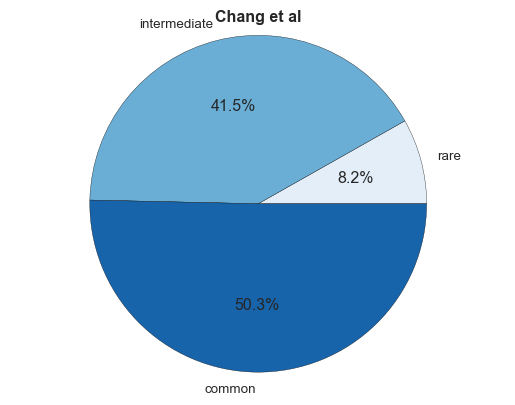

In [70]:
rare_chang_df = pd.read_table('data/rarity_chang_et_al_pancan.txt')
chang_counts = rare_chang_df.groupby('category')['number of mutations'].sum()
with sns.plotting_context('paper', font_scale=1.2):
    blues = sns.color_palette("Blues", 9)
    pie_colors = [blues[0], blues[4], blues[7]]
    labels = ['rare', 'intermediate', 'common']
    plt.pie(chang_counts[labels], colors=pie_colors, labels=labels, autopct='%.1f%%')
    plt.title('Chang et al', fontdict={'verticalalignment': 'bottom', 'fontweight': 'bold'})
    _ = plt.axis('equal')

#### Comparison between CHASM2 and Hotspots

In [71]:
rare_chasm2_df = pd.read_table('data/rarity_analysis_v2/PANCAN.txt')
chasm2_counts = rare_chasm2_df.groupby('category')['number of mutations'].sum()

# compare using a fisher exact test
chasm2_nonrare = chasm2_counts.loc[['common', 'intermediate']].sum()
chasm2_rare = chasm2_counts.loc['rare']
chang_nonrare = chang_counts.loc[['common', 'intermediate']].sum()
chang_rare = chang_counts.loc['rare']
contigency_table = np.array([[chasm2_rare, chang_rare], [chasm2_nonrare, chang_nonrare]])

In [72]:
%%R -i contigency_table
fisher.test(contigency_table)


	Fisher's Exact Test for Count Data

data:  contigency_table
p-value < 2.2e-16
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 5.618475 6.794491
sample estimates:
odds ratio 
  6.174854 



#### Prepare chimera

In [76]:
tmp = rare_chasm2_df.mutation.str.split('_', expand=True)
rare_chasm2_df['gene'] = tmp[0]

In [111]:
is_gene = rare_chasm2_df['gene']=='ERBB2'
format_func = lambda x: ','.join([str(t.split('_')[-1])+'.A' for t in x.mutation])
rare_chasm2_df[is_gene].groupby('category').apply(format_func)

category
common                                                    310.A
intermediate                                  755.A,776.A,842.A
rare            313.A,662.A,678.A,733.A,756.A,767.A,769.A,777.A
dtype: object

In [109]:
df[(df['PANCAN']<=0.01) & (df['Hugo_Symbol']=='ERBB2')]['HGVSp_Short']

41037     p.S310A
48296     p.R678Q
50191     p.V777L
64916     p.S310F
94410     p.L755S
201519    p.L755M
201520    p.L755W
221617    p.G776V
222115    p.T733I
237828    p.V842I
274007    p.D769Y
306519    p.D769H
307919    p.I767M
402214    p.L313V
402428    p.D769N
489072    p.S310Y
514088    p.G776S
522923    p.L662Q
596938    p.R756K
596939    p.I767F
Name: HGVSp_Short, dtype: object

### Gene heatmap

In [19]:
# melt the data frame
cancer_types = [os.path.basename(f)[:-4] for f in glob.glob('{0}/*.txt'.format('data/aggregated_results/')) if 'PANCAN' not in f]
merged2_df = pd.melt(merged_df, 
                     id_vars=['Hugo_Symbol', 'Transcript_ID', 'HGVSp_Short'], value_vars=cancer_types+['PANCAN'],
                     var_name='CODE', value_name='qvalue')
merged2_df = merged2_df.dropna()
merged2_df['Protein_position'] = merged_df['HGVSp_Short'].str[3:-1]

In [20]:
# merge with 
mut_df = pd.read_table('data/aggregated_results/PANCAN.maf')
mut_df = pd.merge(mut_df, merged2_df, 
                  on=['Hugo_Symbol', 'Transcript_ID', 'HGVSp_Short', 'CODE'],
                  how='left')

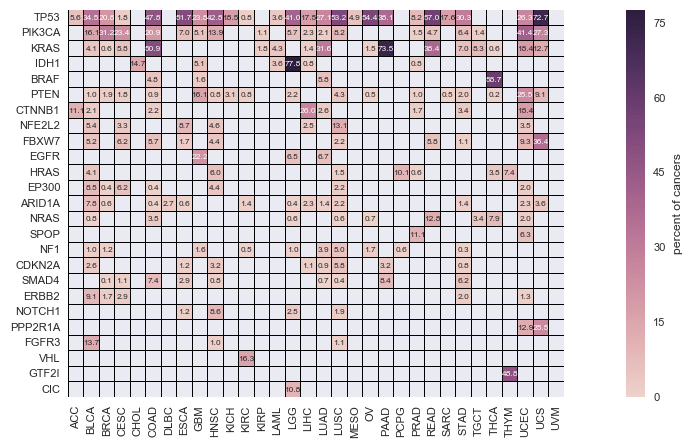

In [21]:
import scipy
from matplotlib.colors import ListedColormap

# calc mutation frequency
mutated_samps = mut_df[mut_df['qvalue']<=.01].groupby(['CODE', 'Hugo_Symbol'])['Tumor_Sample_Barcode'].nunique()
order = mutated_samps.reset_index(name='number of mutations').groupby('Hugo_Symbol')['number of mutations'].sum().sort_values(ascending=False).index.tolist()[:25]
total_samps = mut_df.groupby('CODE')['Tumor_Sample_Barcode'].nunique()
frac_mutated_samps = (mutated_samps / total_samps).reset_index(name='fraction of samples')

# create heatmap
plot_df_orig = frac_mutated_samps.pivot('CODE', 'Hugo_Symbol', 'fraction of samples')
plot_df = plot_df_orig.fillna(0)
with sns.plotting_context('paper'):
    cm = sns.heatmap(100*plot_df.loc[:, order].T, 
                     square=True, 
                     linewidth=.01, linecolor='black', fmt='.1f',
                     annot=100*plot_df_orig.loc[:, order].T,
                     annot_kws={'fontsize': 6},
                     mask=plot_df_orig.loc[:, order].T.isnull(),
                     cbar=True,
                     cbar_kws={'label': 'percent of cancers'},
                     cmap = ListedColormap(sns.color_palette(sns.cubehelix_palette(100).as_hex())))

# modify display of plot
plt.gcf().set_size_inches(16, 5)
plt.ylabel('')
plt.xlabel('')
_ = plt.setp(cm.yaxis.get_majorticklabels(), rotation=0)
_ = plt.setp(cm.xaxis.get_majorticklabels(), rotation=90, ha='center', va='top')

# save figure
#plt.savefig('figures/gene_heatmap.pdf')

### Prepare supplementary tables

Prepare supplementary table 4 showing the significant missense mutations for the pancancer analysis.

In [34]:
pancan_df = read_result('PANCAN')
is_signif = pancan_df['PANCAN'] <= 0.01
pancan_df[is_signif]
dup_cols = ['Hugo_Symbol', 'Transcript_ID', 'HGVSp_Short']
supp_table4 = pancan_df[is_signif].drop_duplicates(dup_cols)
supp_table4 = supp_table4.sort_values(['CHASM2_genome'], ascending=False)
result_cols = ['CODE', 'Hugo_Symbol', 'Transcript_ID', 'HGVSp_Short', 'CHASM2_genome', 'CHASM2_genome_pval', 'PANCAN']
supp_table4[result_cols].to_csv('results/supplementary_table_4_pancan_drivers.txt', sep='\t', index=False)

Prepare supplementary table 5 showing the cancer type specific drivers

In [35]:
is_signif = mut_df['qvalue']<=0.01
dup_cols = ['Hugo_Symbol', 'Transcript_ID', 'HGVSp_Short', 'CODE']
supp_table5 = mut_df[is_signif].drop_duplicates(dup_cols)
supp_table5 = supp_table5.sort_values(['CODE', 'Hugo_Symbol', 'qvalue'])
result_cols = ['CODE', 'Hugo_Symbol', 'Transcript_ID', 'HGVSp_Short', 'qvalue']
supp_table5[result_cols].to_csv('results/supplementary_table_5_cancer_specific_drivers.txt', sep='\t', index=False)